# Percepción Remota
## Carlos Herrera

### 1er intento de visualización de Sargazo

Se utilizará el índice de alga flotante (FAI), adaptado a los canales de GOES-R para intentar identificar colonias de sargazo en el caribe mexicano. 

El índice se define de esta manera: 

FAI = Rrc,NIR – R’rc,NIR
Donde R’NIR = Rr + (RSWIR − Rr) * (λNIR − λr) / (λSWIR−λr)

Traducido a los canales de GOES-R, se puede escribir de este modo: 

FAI = R(Ch3) – { R(Ch2) +  ( R(Ch4) – R(Ch2) ) * (Ch3 – Ch2) / (Ch4 – Ch2)}

R(λ): Reflectancia de λ

Primero trabajaré con las imágenes del 2018-06-28, que es cuando fue visible el polvo del Sahara en el Atlántico. 

Intentaré utilizar unicamente imágenes "CONUS" ya que la imágen del canal 2 de "FULL DISK" pesa casi 480 MB

In [1]:
# Se llaman las librerías a utilizar
import matplotlib.pyplot as plt
%matplotlib
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from datetime import datetime
from pyproj import Proj

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

Using matplotlib backend: Qt5Agg


In [2]:
# Se establece la ruta y nombre de los archivos

ruta = '/Users/Mapache/Desktop/Descargas GOES R/Saharan dust 20180628/Conus/L1 Radiances/'

Ch2 = ruta+"OR_ABI-L1b-RadC-M3C02_G16_s20181791502192_e20181791504565_c20181791505011.nc"
Ch3 = ruta+"OR_ABI-L1b-RadC-M3C03_G16_s20181791502192_e20181791504565_c20181791505015.nc"
Ch4 = ruta+"OR_ABI-L1b-RadC-M3C04_G16_s20181791502192_e20181791504565_c20181791505009.nc"

# Search for the Scan Start in the file name
Start = (Ch2[Ch2.find("_s")+2:Ch2.find("_e")-1])
End = (Ch2[Ch2.find("_e")+2:Ch2.find("_c")-1])

# Format the "Observation Start" string
datetime_start = datetime.strptime(Start,'%Y%j%H%M%S')
datetime_end = datetime.strptime(End,'%Y%j%H%M%S')
print(datetime_start)
print(datetime_end)

2018-06-28 15:02:19
2018-06-28 15:04:56


### Se importan los archivos
Se abren los NetCDF's:

In [3]:
Ch2_nc = Dataset(Ch2)
Ch2_rad = Ch2_nc.variables['Rad'][:]
Ch2_nc.close()
Ch2_nc = None

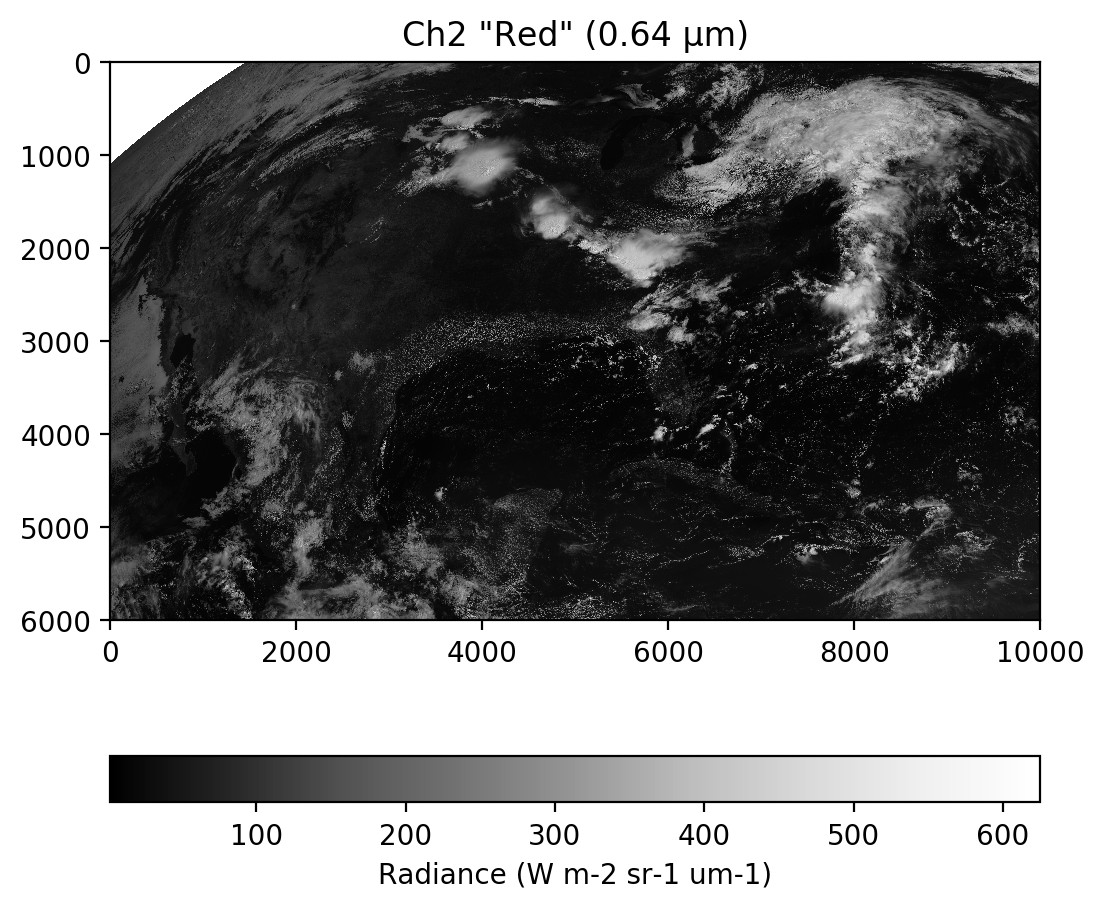

In [4]:
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(Ch2_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch2 "Red" (0.64 µm)')
plt.show()

In [5]:
Ch3_nc = Dataset(Ch3)
Ch3_rad = Ch3_nc.variables['Rad'][:]
Ch3_nc.close()
Ch3_nc = None

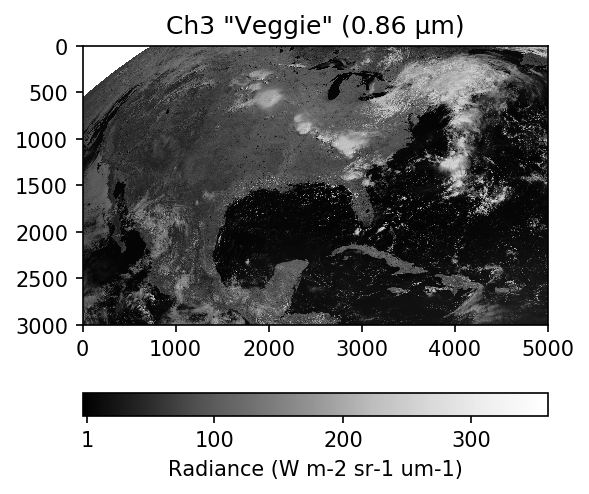

In [6]:
fig = plt.figure(figsize=(4,4),dpi=150)
im = plt.imshow(Ch3_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch3 "Veggie" (0.86 µm)')
plt.show()

In [32]:
Ch4_nc = Dataset(Ch4)
Ch4_rad = Ch4_nc.variables['Rad'][:]

In [34]:
ori_proj = Ch4_nc.variables['goes_imager_projection']
# Satellite height
sat_h = ori_proj.perspective_point_height
# Satellite longitude
sat_lon = ori_proj.longitude_of_projection_origin
# Satellite sweep
sat_sweep = ori_proj.sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = Ch4_nc.variables['x'][:] * sat_h
Y = Ch4_nc.variables['y'][:] * sat_h

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)


In [40]:
#print(Ch4_nc.variables)
#print(Ch4_nc.dimensions)
print(sat_lon)
print(sat_h)
np.shape(lats)

-75.0
35786023.0


(1500, 2500)

In [41]:
print(np.min(lats))
print(np.max(lats))

print(np.min(lons))
print(np.max(lats))

14.571341550746604
1e+30
-151.65486399250764
1e+30


In [44]:
Ch4_nc.close()
Ch4_nc = None

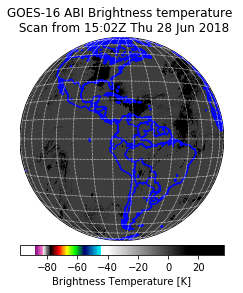

In [46]:
# Plot normal con proyección original
# plt.figure(figsize=(10,10))
bmap = Basemap(projection='geos', lon_0=-75.5, lat_0=0.0, satellite_height=35786023.0, ellps='GRS80', resolution='l')

# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.imshow(Ch4_rad, origin='upper', vmin=175-273.15, vmax=310-273.15, cmap=cpt_convert)
 
# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='blue')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='blue')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.7, color='white')
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.7, color='white')
 
# Insert the legend
bmap.colorbar(location='bottom', label='Brightness Temperature [K]')

date_formatted = datetime.strftime(datetime_start,
                                   '%H:%MZ %a %d %b %Y')
plt.title("GOES-16 ABI Brightness temperature \n Scan from " +date_formatted)

#Export result
# DPI = 300
# plt.savefig('GOES-16_Ch13.png', dpi=DPI, bbox_inches='tight', pad_inches=0)
 
# Show the plot
plt.rcParams['figure.figsize'] = (6,6)
plt.show()

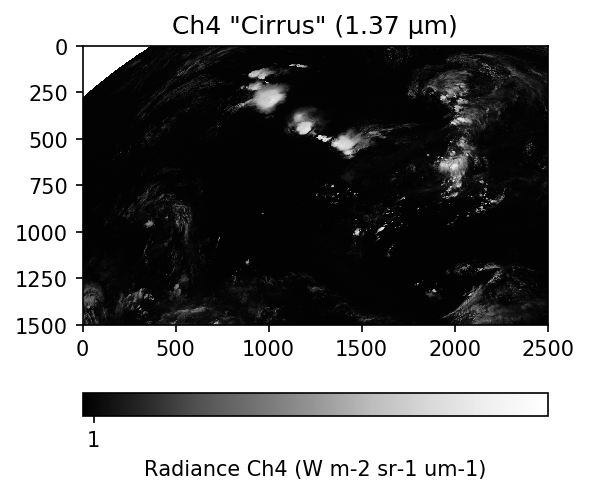

In [8]:
fig = plt.figure(figsize=(4,4),dpi=150)
im = plt.imshow(Ch4_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance Ch4 (W m-2 sr-1 um-1)')
plt.title('Ch4 "Cirrus" (1.37 µm)')
plt.show()

### Se convierten las radiancias a reflectancias 
Se utiliza la función de Olmo

In [9]:
#reflectance(radiancia, numero de banda): convierte la radiancia a reflectancia las bandas 1-6 de GOES 16
def reflectance(radiance, band):
    Esun_dict = {1:441.868715,2:663.274497,3:726.721072,4:679.143879,5:634.454241,6:381.148813}
    Esun = Esun_dict[band]
    d2 = 0.3
    refl = (radiance * np.pi * d2) / Esun
    refl = np.maximum(refl, 0.0)
    refl = np.minimum(refl, 1.0)
    return refl

# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [10]:
Ch2_ref = reflectance(Ch2_rad, band=2)
Ch3_ref = reflectance(Ch3_rad, band=3)
Ch4_ref = reflectance(Ch4_rad, band=4)


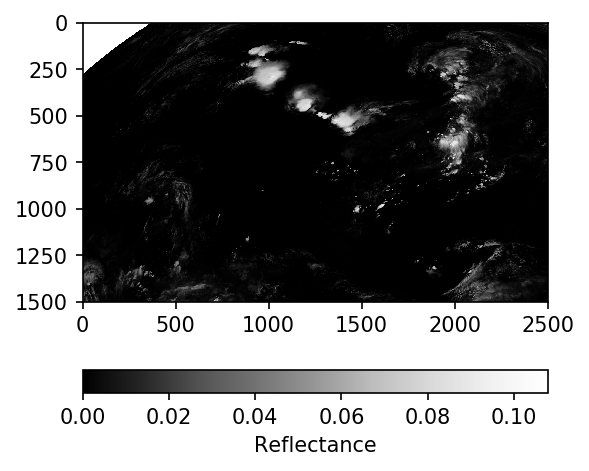

In [24]:
#Graficar la reflectancia:
fig = plt.figure(figsize=(4,4),dpi=150)
im = plt.imshow(Ch4_ref,  cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
#cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
#cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Reflectance')
#plt.title('Ch2 Reflectancia "Red" (0.64 µm)')
plt.show()

### Se construye el FAI

FAI = R(Ch3) – { R(Ch2) + ( R(Ch4) – R(Ch2) ) * (Ch3 – Ch2) / (Ch4 – Ch2)}

In [14]:
# Consulto el tamaño de cada banda
print(np.shape(Ch2_rad))
print(np.shape(Ch3_rad))
print(np.shape(Ch4_rad))

""" La menor resolución la tiene el Canal 4 (2km), así que tendrémos 
que remuestrear los otros dos a 1500, 2500"""

(6000, 10000)
(3000, 5000)
(1500, 2500)


' La menor resolución la tiene el Canal 4 (2km), así que tendrémos \nque remuestrear los otros dos a 1500, 2500'

In [16]:
Ch2_rad_rs = rebin(Ch2_rad, [1500, 2500])
Ch2_ref_rs = rebin(Ch2_ref, [1500, 2500])

Ch3_rad_rs = rebin(Ch3_rad, [1500, 2500])
Ch3_ref_rs = rebin(Ch3_ref, [1500, 2500])

In [18]:
print(np.shape(Ch2_rad_rs))
print(np.shape(Ch3_rad_rs))
print(np.shape(Ch4_rad))

print(np.shape(Ch2_ref_rs))
print(np.shape(Ch3_ref_rs))
print(np.shape(Ch4_ref))


(1500, 2500)
(1500, 2500)
(1500, 2500)
(1500, 2500)
(1500, 2500)
(1500, 2500)


FAI = R(Ch3) – { R(Ch2) + (   R(Ch4) – R(Ch2)  ) * (Ch3 – Ch2) / (Ch4 – Ch2)}

In [25]:
FAI = Ch3_ref_rs - ( Ch2_ref_rs + (Ch4_ref - Ch2_ref_rs) * (Ch3_rad_rs - Ch2_rad_rs)/(Ch4_rad - Ch2_rad_rs))

In [26]:
FAI

masked_array(
  data=[[--, --, --, ..., -0.026155845179961446, -0.026853751974626583,
         -0.026983969273420394],
        [--, --, --, ..., -0.02648686779502779, -0.025991556027470386,
         -0.02678496019731602],
        [--, --, --, ..., -0.024975597626284207, -0.02477095311377936,
         -0.0247927349618271],
        ...,
        [-0.013436789524950477, -0.011635415405879507,
         -0.011457338714943532, ..., -0.0034735931867650033,
         -0.003344991097779873, -0.003391761719799366],
        [-0.015435405279093872, -0.01307386400904026,
         -0.01119580841243445, ..., -0.0058350231717683165,
         -0.003462968805002159, -0.004220683515611098],
        [-0.018336317892424153, -0.01701920952697017,
         -0.013336648917885607, ..., -0.0073896748429567866,
         -0.004980551501656882, -0.007459870891794118]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., 

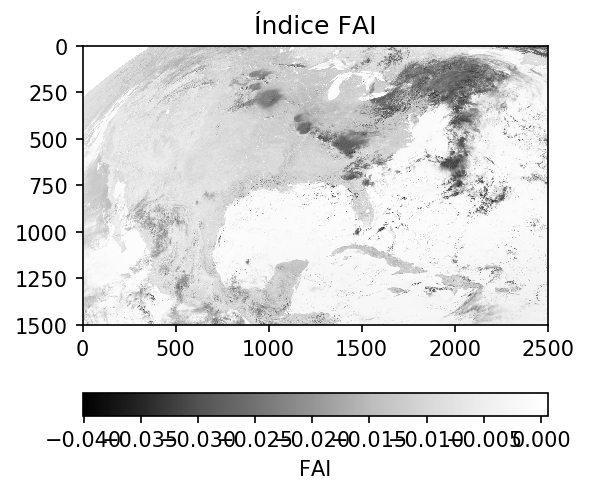

In [30]:
#Graficar el índice FAI
fig = plt.figure(figsize=(4,4),dpi=150)
#im = plt.imshow(Ch2_rad, vmin=0.0, vmax=1.0, cmap='Greys_r')
im = plt.imshow(FAI, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
#cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('FAI')
plt.title('Índice FAI')
plt.show()

A continuación se intenta un zoom:

In [48]:
lons_subset=lons[0:-1,0:-1]
lats_subset=lats[0:-1,0:-1]
FAI_subset=FAI[0:-1,0:-1]

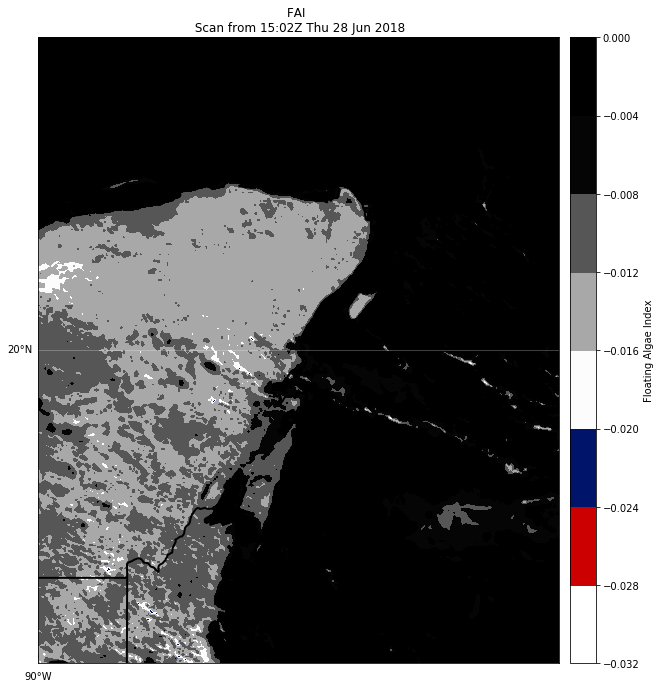

In [62]:
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-85,
               llcrnrlat=17,   urcrnrlat=23,  resolution='h')

# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
#bmap.contourf(lons_subset,lats_subset,FAI_subset,cmap=cpt_convert)
bmap.contourf(lons,lats,FAI,cmap=cpt_convert)

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=2, linestyle='solid', color='black')
bmap.drawcountries(linewidth=2, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

# Insert the legend
bmap.colorbar(location='right', label='Floating Algae Index')

date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("FAI \n Scan from " +date_formatted)

# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()


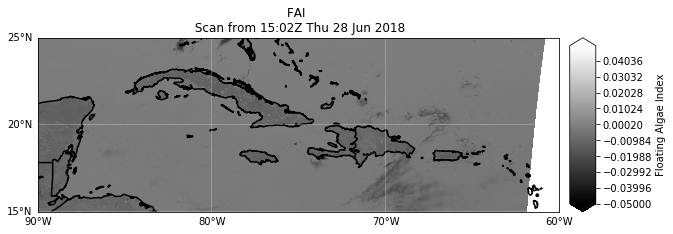

In [65]:
plt.figure(figsize=(10,10))# Create the basemap reference for the Satellite Projection
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=25,  resolution='h')

levels=np.linspace(-0.05, 0.05, 250)
bmap.contourf(lons,lats,FAI, 
              levels=levels, cmap="gist_gray", extend='both')

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

# Insert the legend
bmap.colorbar(location='right', label='Floating Algae Index')

date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("FAI \n Scan from " +date_formatted)

plt.show()

In [61]:
print(np.min(FAI))
print(np.max(FAI))

-0.04008215270274368
0.00056850707521015
